# Tradeoff Problem Example: Podracing

We are entered in the race of the century! Just like Anakin Skywalker, we built our own podracer and are about to begin the race. The official informs us that there are certain “checkpoints” that we need to hit. Our goal is to save as much fuel as possible so we don’t run out during the race.

Before we start the race, we must figure out the appropriate thruster burns at each instant.
 * We’ll (approximately) model thrust as a 2D vector containing info on direction change
 * Amount of fuel we consume when we use thrusters is calculated as $L_2$ norm of thrust vector
 * Suppose the officials aren’t watching the checkpoints very closely, so long as we “sort of” hit the checkpoints we’ll be okay

 In this version of the problem, we'll enforce the constraints in a "soft" manner with a box of feasbility.
 For each component of the position vector, we ensure that it is at most $\beta/2$ units away from the given value

In [1]:
using JuMP, HiGHS

k = 4              # number of checkpoints
T = zeros(Int,k)   # vector of timepoints
xw = zeros(2,k)    # vector of checkpoint locations

# times at which we must hit checkpoints
T[1] = 1
T[2] = 20
T[3] = 50
T[4] = 60

# define checkpoints' x and y coords
way_xy = [ 1   4   6   1
           1   3   0   1 ]

# create a function that takes a value for β then solves and reports solution of tradeoff problem
function solveOpt(β)
    
    m = Model(HiGHS.Optimizer) # This is a quadratic objective, so need the right solver.
    set_silent(m)
    @variable(m, x[1:2,1:T[k]])  # position at each time
    @variable(m, v[1:2,1:T[k]])  # velocity at each time
    @variable(m, u[1:2,1:T[k]])  # thruster input at each time

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== [0;0])
    @constraint(m, x[:,1] .== [1;1])
    # model system dynamics
    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end

    # hit all the checkpoints within a box of side length β
    for i in 1:k
        @constraint(m, x[:,T[i]] .<= way_xy[:,i] + β/2*ones(2))
        @constraint(m, x[:,T[i]] .>= way_xy[:,i] - β/2*ones(2))
    end

    # minimize 2-norm
    @objective(m, Min, sum(u.^2))
    optimize!(m)
    y1 = value(sum(u.^2))
    y2 = β
    xopt = value.(x)
    
    return (y1,y2,xopt)
end
;

## Plot Model Output

We can visualize our solution by plotting the output below:


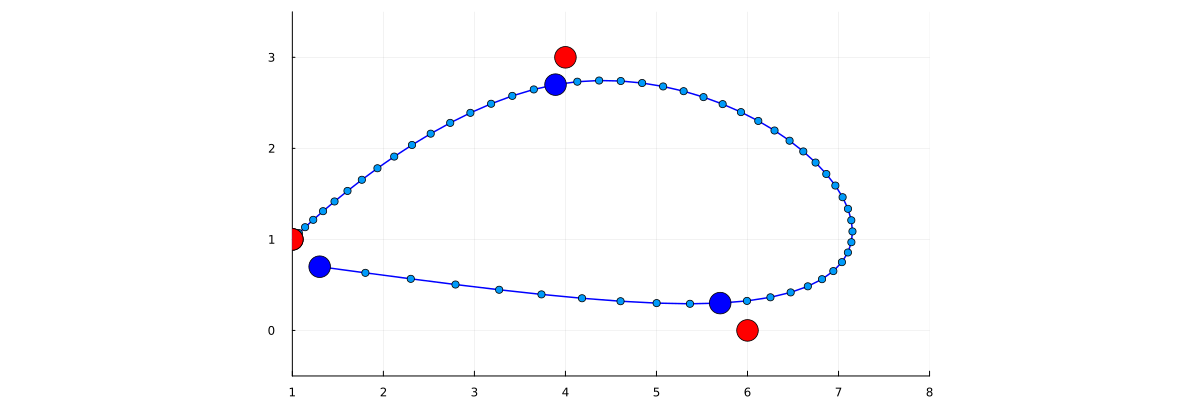

In [2]:

β = 0.6 # choose a value for β
(y1x,y2x,x) = solveOpt(β) # solve model with given β

# plot the solution against the checkpoints
using Plots

# Set figure size to match figsize=(12,4) → approx. 1200x400 pixels
default(size=(1200, 400))

# Plot the trajectory (blue line with dots)
plot(x[1, :], x[2, :],
     linecolor = :blue,
     marker = :circle,
     markersize = 4,
     linewidth = 1.5,
     label = "")

# Highlight the T-th point on the trajectory (large blue dot)
scatter!([x[1, T]], [x[2, T]],
         color = :blue,
         markersize = 12,
         label = "")

# Plot the waypoints (red dots)
scatter!(way_xy[1, :], way_xy[2, :],
         color = :red,
         markersize = 12,
         label = "")

# Set axis aspect ratio and limits
plot!(aspect_ratio = :equal,
      xlims = (1.0, 8.0),
      ylims = (-0.5, 3.5))

## Compute tradeoff curve

Now let's compute the Pareto curve for many values of $\beta$

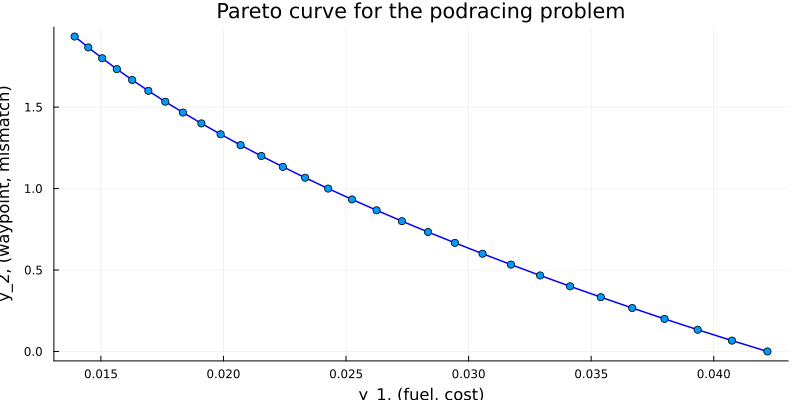

In [3]:
Npts = 30
MaxDev = 2.0

y1 = zeros(Npts)
y2 = zeros(Npts)

for (i,β) in [(i,MaxDev*i/Npts - MaxDev/Npts) for i in 1:Npts]
    (y1[i],y2[i],uu) = solveOpt(β)
end;

# plot the points
default(size=(800, 400))

# Plot the Pareto curve
plot(y1, y2, 
     linecolor = :blue, 
     marker = :circle, 
     markersize = 4, 
     linewidth = 1.5, 
     label = "")

# Set LaTeX-style axis labels and title
xlabel!("y_1, (fuel, cost)")
ylabel!("y_2, (waypoint, mismatch)")
title!("Pareto curve for the podracing problem")